# Brain Tumor Detection
This Notebook will go through different libraries, custom dataset generator and Neural Network function along with results

<b><u>Contents</u></b>
* Libraries Import
* Custom Data Generator
* Custom Network Implementation
* Model Training
* Results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
%matplotlib inline

In [2]:
# Need to check if cuda is avaiable, to shift tensors and network to GPUs
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

## Custom Data Generator

A lot of effort in solving any machine learning problem goes into preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable. In this tutorial, we will see how to load and preprocess/augment data from a non trivial dataset.

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

```__len__``` so that len(dataset) returns the size of the dataset.<br>
```__getitem__``` to support the indexing such that dataset[i] can be used to get i<sup>th</sup> sample.

**Below Cell Explanation**

```__init__```: In this section, we have created a dataframe, where First column will be having the image path and second column containing labels, along with that shuffled the dataset.<br>

```__len__```: In this section, return the sum of files present in both folder <br>
```__getitem__```: In this Section, as idx can be single integer or slicing, therefore need to return the images in grayscale (as many of the images are in grayscale and some of them are in RGB Channel, so converted into one), and return the Torch tensor array with labels

Learn More: [Pytorch Data Loading Documentation](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [3]:
from glob import glob
class BrainMRIDataset(Dataset):
    
    def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder=False):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.autoencoder = autoencoder
        
        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]
        
        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })
        
        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)
        
    def __len__(self):
        return len(self.no_class)+len(self.yes_class)
    
    def __getitem__(self,idx):
        
        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]
        
        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)
        
            if self.autoencoder:
                array = array.reshape(self.height*self.width)
            else:
                array = array.reshape(1,self.height,self.width)
            
            image_array.append(array)
        
        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]
    
    def __repr__(self):
        return str(self.dataframe.head())

In [4]:
dataset = BrainMRIDataset("../input/brain-mri-images-for-brain-tumor-detection")
print(dataset)

                                               image  labels
0  ../input/brain-mri-images-for-brain-tumor-dete...       1
1  ../input/brain-mri-images-for-brain-tumor-dete...       1
2  ../input/brain-mri-images-for-brain-tumor-dete...       0
3  ../input/brain-mri-images-for-brain-tumor-dete...       1
4  ../input/brain-mri-images-for-brain-tumor-dete...       1


## Custom Neural Network Class

This class will inherit the properties from ```torch.nn.Module``` and should have two functions ```__init__``` for defining neural network and ```forward``` for forward propogation. In General, forward function, will be dealing with output from each layer. We can apply MaxPool, Dropouts and other activation functions.

In [5]:
class BrainTumorModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,256,kernel_size=3),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,32,kernel_size=2)
        )
        self.linear1 = nn.Linear(62,128)
        self.linear2 = nn.Linear(128,64)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(126976,2)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [6]:
model = BrainTumorModel()
model.to(device)

BrainTumorModel(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(256, 32, kernel_size=(2, 2), stride=(1, 1))
  )
  (linear1): Linear(in_features=62, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=126976, out_features=2, bias=True)
)

# Convolutional Neural Network - Classification

## Model Training

1. Loss Function: ```torch.nn``` Module having predefined loss functions and you can create your own Loss functions as defined above. Using CrossEntropyLoss for 2 Outputs, for examining the individual probabilities

2. Optimizer: ```torch.nn``` having pre-defined optimizers, with many parameters, using Adam here

3. After defining epochs, need to loop over some steps
    * Fitting Data with batch of dataset
    * Compute the Loss
    * Make Gradient Zero, for previous computations
    * Compute the backward propogation (Derivate calculation)
    * Optimizing the weight and biases

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [8]:
epochs = 200
batch_size = 32
loss_list = []
for epoch in range(epochs):
    total_loss = 0
    for n in range(len(dataset)//batch_size):
    
        data,target = dataset[n*batch_size:(n+1)*batch_size]

        ypred = model.forward(data.float())
        loss = loss_fn(ypred,target)

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    if epoch%10 == 0:
        print(f'Epochs: {epoch} Loss: {total_loss/n}')

Epochs: 0 Loss: 27.31191062927246
Epochs: 10 Loss: 0.33092617988586426
Epochs: 20 Loss: 0.06470140069723129
Epochs: 30 Loss: 0.03661302849650383
Epochs: 40 Loss: 0.01438432838767767
Epochs: 50 Loss: 0.004625989124178886
Epochs: 60 Loss: 0.002133619971573353
Epochs: 70 Loss: 0.00124434067402035
Epochs: 80 Loss: 0.0008251121616922319
Epochs: 90 Loss: 0.0005896356888115406
Epochs: 100 Loss: 0.00044287051423452795
Epochs: 110 Loss: 0.0003457151760812849
Epochs: 120 Loss: 0.0002777285408228636
Epochs: 130 Loss: 0.0002281098859384656
Epochs: 140 Loss: 0.00019021185289602727
Epochs: 150 Loss: 0.00016056609456427395
Epochs: 160 Loss: 0.0001370691752526909
Epochs: 170 Loss: 0.00011822277883766219
Epochs: 180 Loss: 0.00010291798389516771
Epochs: 190 Loss: 9.034520189743489e-05


## Results
Underlying contains two plots, Loss and Prediction 

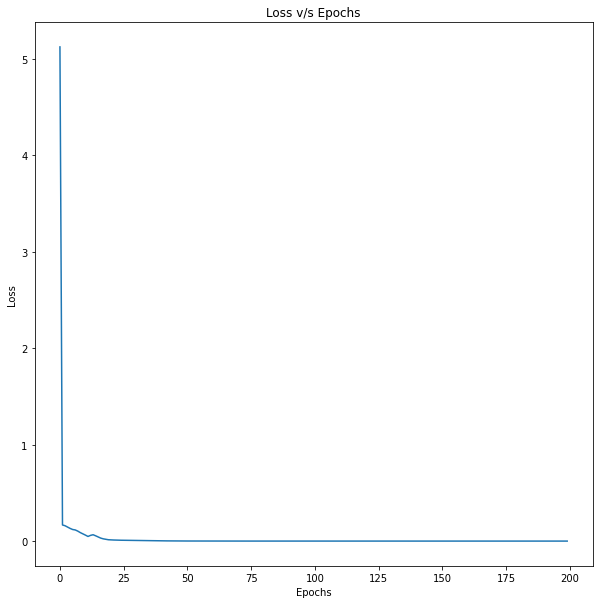

In [9]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

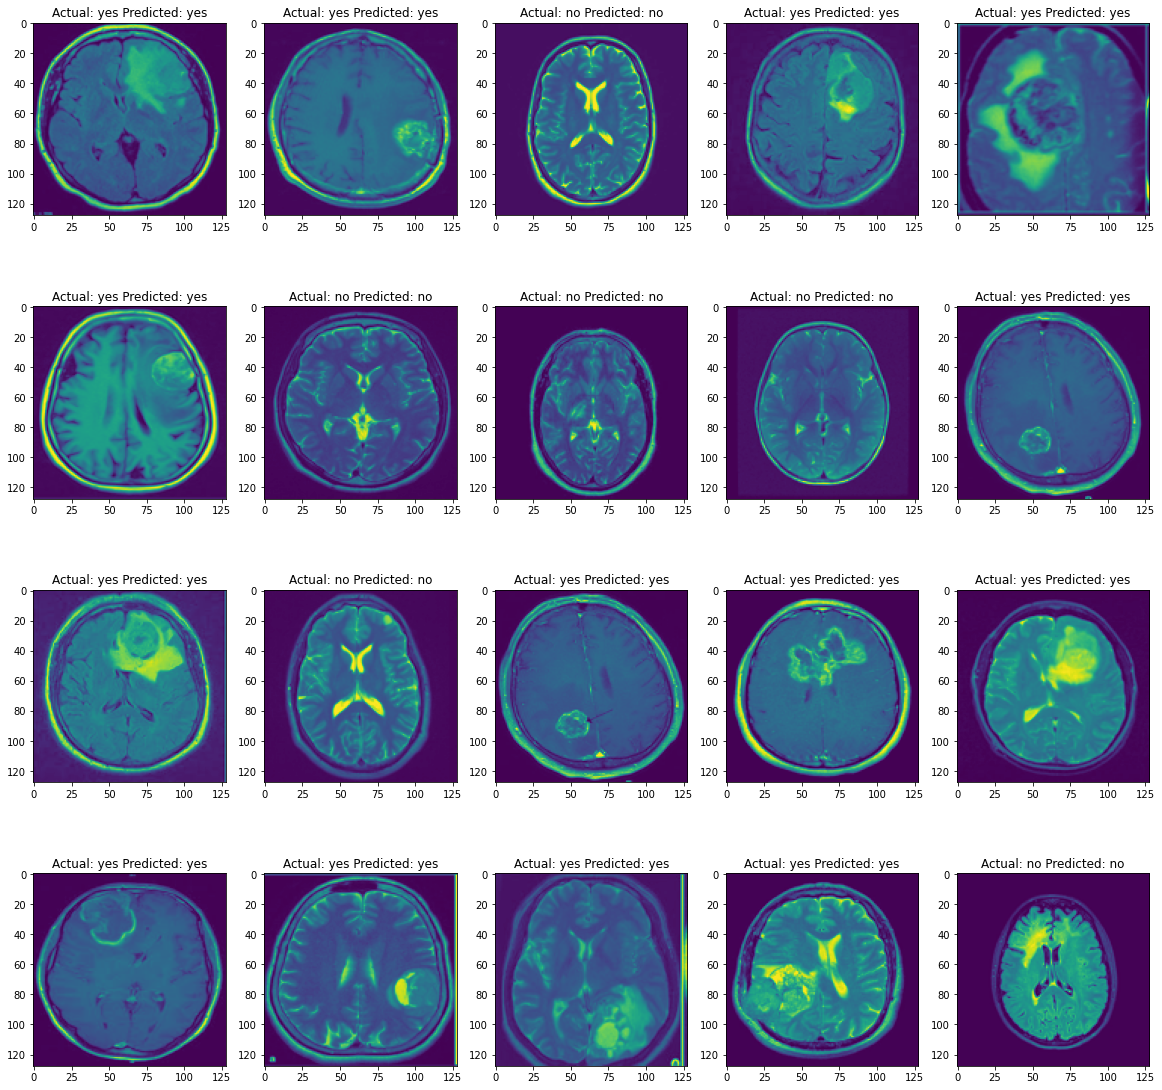

In [10]:
mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
for i in range(20):
    data,target = dataset[i]
    pred = model.forward(data.float())
    pred = torch.argmax(pred,dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(data[0][0].cpu())
    plt.title(f'Actual: {mapping[target.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
plt.show()

# Autoencoder
In this section, we will be looking into an Autoencoder Implementation, which will try to understand the underlying distribution of Data, and try to create brain images using Models.

In [11]:
dataset_autoencoder = BrainMRIDataset("../input/brain-mri-images-for-brain-tumor-detection",autoencoder=True,height=28,width=28)

In [12]:
class BrainTumorAutoencodes(nn.Module):
    
    def __init__(self,dim):
        
        super().__init__()
        self.lin1 = nn.Linear(dim*dim,542)
        self.lin2 = nn.Linear(542,345)
        self.lin3 = nn.Linear(345,128)
        self.lin4 = nn.Linear(128,64)
        self.lin5 = nn.Linear(64,32)
        self.lin6 = nn.Linear(32,64)
        self.lin7 = nn.Linear(64,128)
        self.lin8 = nn.Linear(128,345)
        self.lin9 = nn.Linear(345,542)
        self.lin10 = nn.Linear(542,dim*dim)

    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = self.lin5(x)
        x = F.relu(self.lin6(x))
        x = F.relu(self.lin7(x))
        x = self.lin8(x)
        x = F.relu(self.lin9(x))
        x = F.relu(self.lin10(x))

        return x
        

In [13]:
autoencoder = BrainTumorAutoencodes(28)
autoencoder.to(device)

BrainTumorAutoencodes(
  (lin1): Linear(in_features=784, out_features=542, bias=True)
  (lin2): Linear(in_features=542, out_features=345, bias=True)
  (lin3): Linear(in_features=345, out_features=128, bias=True)
  (lin4): Linear(in_features=128, out_features=64, bias=True)
  (lin5): Linear(in_features=64, out_features=32, bias=True)
  (lin6): Linear(in_features=32, out_features=64, bias=True)
  (lin7): Linear(in_features=64, out_features=128, bias=True)
  (lin8): Linear(in_features=128, out_features=345, bias=True)
  (lin9): Linear(in_features=345, out_features=542, bias=True)
  (lin10): Linear(in_features=542, out_features=784, bias=True)
)

In [14]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())

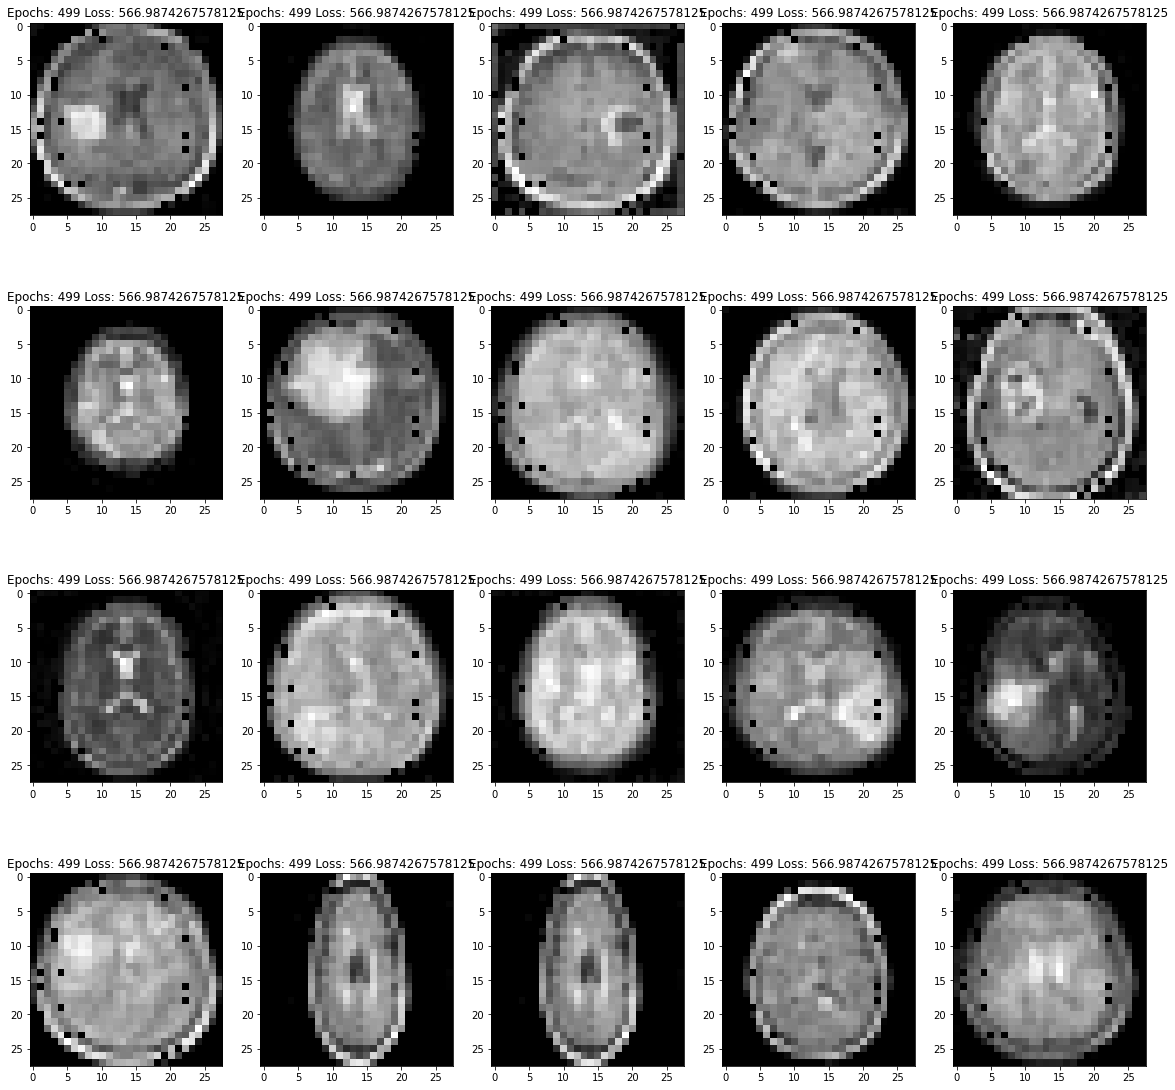

In [15]:
from IPython.display import clear_output
epochs = 500
batch_size = 32
loss_list = []
for epoch in range(epochs):
    clear_output(True)
    total_loss = 0
    for n in range(len(dataset_autoencoder)//batch_size):
    
        data,target = dataset_autoencoder[n*batch_size:(n+1)*batch_size]

        ypred = autoencoder.forward(data.float())
        loss = loss_fn(ypred,data.float())

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    
    figure = plt.figure(figsize=(20,20))
    for i in range(20):
        plt.subplot(4,5,i+1)
        image = ypred[i].cpu().detach().numpy()# plot the sample
        image = image.reshape(28,28)
        fig = plt.figure
        plt.imshow(image, cmap='gray')
        plt.title(f'Epochs: {epoch} Loss: {total_loss/n}')
    plt.show()